# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [18]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.03763718  0.22172602 -0.03328692 -0.27780089] 1 1.0 False {}
state, action, reward, done, info: [-0.03320266  0.02709437 -0.03884294  0.00420031] 0 1.0 False {}
state, action, reward, done, info: [-0.03266077 -0.16744961 -0.03875893  0.28437922] 0 1.0 False {}
state, action, reward, done, info: [-0.03600977  0.02820309 -0.03307135 -0.02027169] 1 1.0 False {}
state, action, reward, done, info: [-0.0354457  -0.16642936 -0.03347678  0.26179613] 0 1.0 False {}
state, action, reward, done, info: [-0.03877429 -0.36105784 -0.02824086  0.54373496] 0 1.0 False {}
state, action, reward, done, info: [-0.04599545 -0.55577178 -0.01736616  0.82738769] 0 1.0 False {}
state, action, reward, done, info: [-5.71108834e-02 -7.50652024e-01 -8.18407122e-04  1.11455858e+00] 0 1.0 False {}
state, action, reward, done, info: [-0.07212392 -0.94576322  0.02147276  1.40698466] 0 1.0 False {}
state, action, reward, done, info: [-0.09103919 -0.75091423  0.04961246  1.12109107]

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [19]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [20]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [21]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [22]:
def model_loss(states, actions, targetQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    
    # Calculating action logits: Used to calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # # Calculating targetQs using NEW memory using rewards
    # rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
    
    # # Calculating Qs using NEW memory using actions
    # Onehot vectorizing the actions logits
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [23]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [24]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [25]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [26]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:1


In [27]:
# Training parameters
train_episodes = 3000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [28]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [30]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [31]:
state, reward, action

(array([-0.10203971,  0.04099036,  0.04412475, -0.097248  ]), 1.0, 1)

In [32]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            
            # Take new action, get new state and reward
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating targetQs/nextQs using NEW memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.targetQs: Qs} # labelQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 9.0 Average loss: 0.0297 Explore P: 0.9990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 32.0 Average loss: 0.0598 Explore P: 0.9958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 10.0 Average loss: 0.0650 Explore P: 0.9947
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 14.0 Average loss: 0.0641 Explore P: 0.9932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episo

-------------------------------------------------------------------------------
Episode: 37 Total reward: 43.0 Average loss: 0.0615 Explore P: 0.9177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 19.0 Average loss: 0.0564 Explore P: 0.9159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 13.0 Average loss: 0.0573 Explore P: 0.9146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 40 Total reward: 19.0 Average loss: 0.0592 Explore P: 0.9128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 74 Total reward: 39.0 Average loss: 0.0546 Explore P: 0.8323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 75 Total reward: 61.0 Average loss: 0.0498 Explore P: 0.8272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 76 Total reward: 14.0 Average loss: 0.0418 Explore P: 0.8260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 77 Total reward: 27.0 Average loss: 0.0383 Explore P: 0.8237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 110 Total reward: 78.0 Average loss: 0.0347 Explore P: 0.7468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 111 Total reward: 13.0 Average loss: 0.0332 Explore P: 0.7458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 112 Total reward: 77.0 Average loss: 0.0335 Explore P: 0.7400
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 113 Total reward: 29.0 Average loss: 0.0350 Explore P: 0.7379
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 146 Total reward: 88.0 Average loss: 0.0669 Explore P: 0.6602
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 21.0 Average loss: 0.0823 Explore P: 0.6587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 148 Total reward: 19.0 Average loss: 0.0813 Explore P: 0.6574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 28.0 Average loss: 0.0809 Explore P: 0.6556
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 182 Total reward: 22.0 Average loss: 0.0585 Explore P: 0.5750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 15.0 Average loss: 0.0577 Explore P: 0.5741
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 80.0 Average loss: 0.0554 Explore P: 0.5696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 37.0 Average loss: 0.0712 Explore P: 0.5675
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 218 Total reward: 58.0 Average loss: 0.0686 Explore P: 0.4867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 219 Total reward: 36.0 Average loss: 0.0567 Explore P: 0.4849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 220 Total reward: 26.0 Average loss: 0.0423 Explore P: 0.4837
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 221 Total reward: 28.0 Average loss: 0.0422 Explore P: 0.4823
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 254 Total reward: 42.0 Average loss: 0.0976 Explore P: 0.3805
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 23.0 Average loss: 0.0974 Explore P: 0.3796
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 73.0 Average loss: 0.0979 Explore P: 0.3769
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 93.0 Average loss: 0.0841 Explore P: 0.3735
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 290 Total reward: 174.0 Average loss: 0.1089 Explore P: 0.2913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 291 Total reward: 101.0 Average loss: 0.1332 Explore P: 0.2884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 292 Total reward: 25.0 Average loss: 0.1552 Explore P: 0.2877
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 293 Total reward: 70.0 Average loss: 0.1385 Explore P: 0.2858
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 326 Total reward: 96.0 Average loss: 0.1126 Explore P: 0.2280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 89.0 Average loss: 0.1107 Explore P: 0.2261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 16.0 Average loss: 0.1139 Explore P: 0.2257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 51.0 Average loss: 0.1077 Explore P: 0.2246
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 362 Total reward: 44.0 Average loss: 0.1246 Explore P: 0.1813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 84.0 Average loss: 0.1109 Explore P: 0.1799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 32.0 Average loss: 0.1078 Explore P: 0.1793
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 39.0 Average loss: 0.0950 Explore P: 0.1786
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 398 Total reward: 119.0 Average loss: 0.1055 Explore P: 0.1332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 113.0 Average loss: 0.0914 Explore P: 0.1318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 92.0 Average loss: 0.0995 Explore P: 0.1306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 94.0 Average loss: 0.1276 Explore P: 0.1295
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 435 Total reward: 107.0 Average loss: 0.1070 Explore P: 0.0973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 117.0 Average loss: 0.1064 Explore P: 0.0962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 437 Total reward: 100.0 Average loss: 0.1168 Explore P: 0.0954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 80.0 Average loss: 0.1418 Explore P: 0.0947
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 471 Total reward: 199.0 Average loss: 0.1586 Explore P: 0.0722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 472 Total reward: 131.0 Average loss: 0.1269 Explore P: 0.0714
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 473 Total reward: 112.0 Average loss: 0.0976 Explore P: 0.0707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 474 Total reward: 29.0 Average loss: 0.0842 Explore P: 0.0705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 507 Total reward: 107.0 Average loss: 0.1313 Explore P: 0.0551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 98.0 Average loss: 0.1318 Explore P: 0.0546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 24.0 Average loss: 0.1339 Explore P: 0.0545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 93.0 Average loss: 0.1307 Explore P: 0.0541
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 543 Total reward: 97.0 Average loss: 0.1137 Explore P: 0.0421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 544 Total reward: 118.0 Average loss: 0.1142 Explore P: 0.0418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 545 Total reward: 91.0 Average loss: 0.1354 Explore P: 0.0415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 546 Total reward: 105.0 Average loss: 0.1363 Explore P: 0.0411
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 579 Total reward: 97.0 Average loss: 0.1437 Explore P: 0.0328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 28.0 Average loss: 0.1531 Explore P: 0.0328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 42.0 Average loss: 0.1345 Explore P: 0.0327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 582 Total reward: 93.0 Average loss: 0.1361 Explore P: 0.0325
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 615 Total reward: 104.0 Average loss: 0.1577 Explore P: 0.0263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 616 Total reward: 86.0 Average loss: 0.1558 Explore P: 0.0262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 107.0 Average loss: 0.1544 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 93.0 Average loss: 0.1502 Explore P: 0.0259
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 651 Total reward: 33.0 Average loss: 0.0833 Explore P: 0.0217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 88.0 Average loss: 0.0907 Explore P: 0.0216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 176.0 Average loss: 0.1002 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 124.0 Average loss: 0.0692 Explore P: 0.0212
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 687 Total reward: 87.0 Average loss: 0.1473 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 95.0 Average loss: 0.1509 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 689 Total reward: 169.0 Average loss: 0.1441 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 690 Total reward: 90.0 Average loss: 0.1237 Explore P: 0.0179
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 723 Total reward: 106.0 Average loss: 0.1215 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 108.0 Average loss: 0.0980 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 86.0 Average loss: 0.0986 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 726 Total reward: 97.0 Average loss: 0.1093 Explore P: 0.0157
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 759 Total reward: 91.0 Average loss: 0.1103 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 760 Total reward: 121.0 Average loss: 0.1144 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 101.0 Average loss: 0.1170 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 118.0 Average loss: 0.1212 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 795 Total reward: 90.0 Average loss: 0.1697 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 796 Total reward: 83.0 Average loss: 0.1699 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 797 Total reward: 99.0 Average loss: 0.1694 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 798 Total reward: 85.0 Average loss: 0.1686 Explore P: 0.0129
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 831 Total reward: 43.0 Average loss: 0.1559 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 199.0 Average loss: 0.1252 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 129.0 Average loss: 0.0957 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 107.0 Average loss: 0.0858 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 867 Total reward: 100.0 Average loss: 0.1532 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 100.0 Average loss: 0.1497 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 78.0 Average loss: 0.1504 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 126.0 Average loss: 0.1479 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 903 Total reward: 128.0 Average loss: 0.1365 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 93.0 Average loss: 0.1475 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 147.0 Average loss: 0.1486 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 89.0 Average loss: 0.1472 Explore P: 0.0110
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 939 Total reward: 167.0 Average loss: 0.1143 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 108.0 Average loss: 0.1337 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 92.0 Average loss: 0.1381 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 97.0 Average loss: 0.1393 Explore P: 0.0107
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 975 Total reward: 96.0 Average loss: 0.1246 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 976 Total reward: 153.0 Average loss: 0.1075 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 119.0 Average loss: 0.0902 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 104.0 Average loss: 0.1151 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1011 Total reward: 103.0 Average loss: 0.0890 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1012 Total reward: 95.0 Average loss: 0.0936 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1013 Total reward: 115.0 Average loss: 0.1171 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1014 Total reward: 86.0 Average loss: 0.1266 Explore P: 0.0103
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1047 Total reward: 125.0 Average loss: 0.1069 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1048 Total reward: 97.0 Average loss: 0.1110 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1049 Total reward: 94.0 Average loss: 0.1122 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1050 Total reward: 89.0 Average loss: 0.1380 Explore P: 0.0102
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1083 Total reward: 89.0 Average loss: 0.1670 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1084 Total reward: 99.0 Average loss: 0.1672 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1085 Total reward: 102.0 Average loss: 0.1639 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1086 Total reward: 102.0 Average loss: 0.1599 Explore P: 0.0102
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1119 Total reward: 103.0 Average loss: 0.1619 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1120 Total reward: 101.0 Average loss: 0.1620 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1121 Total reward: 92.0 Average loss: 0.1593 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1122 Total reward: 88.0 Average loss: 0.1640 Explore P: 0.0101
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1155 Total reward: 115.0 Average loss: 0.1611 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1156 Total reward: 107.0 Average loss: 0.1566 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1157 Total reward: 198.0 Average loss: 0.1390 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1158 Total reward: 102.0 Average loss: 0.1068 Explore P: 0.0101
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1191 Total reward: 99.0 Average loss: 0.1306 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1192 Total reward: 91.0 Average loss: 0.1371 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1193 Total reward: 112.0 Average loss: 0.1321 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1194 Total reward: 113.0 Average loss: 0.1390 Explore P: 0.0101
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1228 Total reward: 24.0 Average loss: 0.1544 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 103.0 Average loss: 0.1469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 102.0 Average loss: 0.1413 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 115.0 Average loss: 0.1334 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1264 Total reward: 102.0 Average loss: 0.1603 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 107.0 Average loss: 0.1614 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1266 Total reward: 22.0 Average loss: 0.1595 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1267 Total reward: 28.0 Average loss: 0.1556 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1300 Total reward: 99.0 Average loss: 0.1624 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1301 Total reward: 116.0 Average loss: 0.1595 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1302 Total reward: 97.0 Average loss: 0.1572 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1303 Total reward: 122.0 Average loss: 0.1508 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1336 Total reward: 89.0 Average loss: 0.1182 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1337 Total reward: 107.0 Average loss: 0.1270 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1338 Total reward: 94.0 Average loss: 0.1400 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1339 Total reward: 99.0 Average loss: 0.1364 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1372 Total reward: 33.0 Average loss: 0.1283 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1373 Total reward: 93.0 Average loss: 0.1182 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1374 Total reward: 199.0 Average loss: 0.1344 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1375 Total reward: 105.0 Average loss: 0.1283 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1408 Total reward: 96.0 Average loss: 0.1541 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 95.0 Average loss: 0.1568 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1410 Total reward: 199.0 Average loss: 0.1575 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1411 Total reward: 82.0 Average loss: 0.1412 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1444 Total reward: 98.0 Average loss: 0.1488 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1445 Total reward: 97.0 Average loss: 0.1473 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1446 Total reward: 162.0 Average loss: 0.1454 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1447 Total reward: 84.0 Average loss: 0.1438 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1480 Total reward: 90.0 Average loss: 0.1186 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1481 Total reward: 86.0 Average loss: 0.1243 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1482 Total reward: 103.0 Average loss: 0.1270 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1483 Total reward: 87.0 Average loss: 0.1172 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1516 Total reward: 113.0 Average loss: 0.1444 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1517 Total reward: 102.0 Average loss: 0.1573 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1518 Total reward: 99.0 Average loss: 0.1525 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1519 Total reward: 199.0 Average loss: 0.1449 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1552 Total reward: 29.0 Average loss: 0.1067 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1553 Total reward: 172.0 Average loss: 0.0944 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1554 Total reward: 199.0 Average loss: 0.1256 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1555 Total reward: 127.0 Average loss: 0.1150 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1588 Total reward: 114.0 Average loss: 0.1398 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1589 Total reward: 28.0 Average loss: 0.1455 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1590 Total reward: 93.0 Average loss: 0.1255 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1591 Total reward: 90.0 Average loss: 0.1126 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1624 Total reward: 94.0 Average loss: 0.1121 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1625 Total reward: 116.0 Average loss: 0.1143 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1626 Total reward: 106.0 Average loss: 0.1398 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1627 Total reward: 88.0 Average loss: 0.1628 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1660 Total reward: 86.0 Average loss: 0.1091 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1661 Total reward: 28.0 Average loss: 0.1058 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1662 Total reward: 91.0 Average loss: 0.1128 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1663 Total reward: 94.0 Average loss: 0.1373 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1696 Total reward: 87.0 Average loss: 0.1159 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1697 Total reward: 97.0 Average loss: 0.1382 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1698 Total reward: 101.0 Average loss: 0.1473 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1699 Total reward: 94.0 Average loss: 0.1482 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1732 Total reward: 104.0 Average loss: 0.1179 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1733 Total reward: 82.0 Average loss: 0.1408 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1734 Total reward: 199.0 Average loss: 0.1455 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1735 Total reward: 93.0 Average loss: 0.1411 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1768 Total reward: 101.0 Average loss: 0.1501 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1769 Total reward: 86.0 Average loss: 0.1501 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1770 Total reward: 117.0 Average loss: 0.1468 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1771 Total reward: 199.0 Average loss: 0.1380 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1804 Total reward: 106.0 Average loss: 0.1303 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1805 Total reward: 89.0 Average loss: 0.1407 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1806 Total reward: 100.0 Average loss: 0.1514 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1807 Total reward: 107.0 Average loss: 0.1539 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1840 Total reward: 92.0 Average loss: 0.1232 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1841 Total reward: 109.0 Average loss: 0.1268 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1842 Total reward: 91.0 Average loss: 0.1274 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 93.0 Average loss: 0.1445 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1876 Total reward: 78.0 Average loss: 0.1439 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 199.0 Average loss: 0.1473 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1878 Total reward: 44.0 Average loss: 0.1378 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1879 Total reward: 91.0 Average loss: 0.1240 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1912 Total reward: 87.0 Average loss: 0.1198 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1913 Total reward: 91.0 Average loss: 0.1391 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1914 Total reward: 89.0 Average loss: 0.1605 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1915 Total reward: 113.0 Average loss: 0.1591 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1948 Total reward: 89.0 Average loss: 0.1524 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1949 Total reward: 22.0 Average loss: 0.1563 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1950 Total reward: 25.0 Average loss: 0.1538 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1951 Total reward: 106.0 Average loss: 0.1399 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1985 Total reward: 29.0 Average loss: 0.1149 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1986 Total reward: 100.0 Average loss: 0.1078 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1987 Total reward: 82.0 Average loss: 0.1191 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1988 Total reward: 90.0 Average loss: 0.1249 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2021 Total reward: 118.0 Average loss: 0.1492 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2022 Total reward: 96.0 Average loss: 0.1523 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2023 Total reward: 102.0 Average loss: 0.1524 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2024 Total reward: 133.0 Average loss: 0.1382 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2057 Total reward: 95.0 Average loss: 0.1070 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2058 Total reward: 23.0 Average loss: 0.1219 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2059 Total reward: 21.0 Average loss: 0.1157 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2060 Total reward: 90.0 Average loss: 0.1054 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2094 Total reward: 27.0 Average loss: 0.0816 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2095 Total reward: 119.0 Average loss: 0.0673 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2096 Total reward: 92.0 Average loss: 0.0663 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2097 Total reward: 82.0 Average loss: 0.0890 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2130 Total reward: 34.0 Average loss: 0.1615 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2131 Total reward: 106.0 Average loss: 0.1555 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2132 Total reward: 101.0 Average loss: 0.1548 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2133 Total reward: 95.0 Average loss: 0.1560 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2166 Total reward: 106.0 Average loss: 0.1488 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2167 Total reward: 26.0 Average loss: 0.1573 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2168 Total reward: 105.0 Average loss: 0.1455 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2169 Total reward: 20.0 Average loss: 0.1484 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2202 Total reward: 82.0 Average loss: 0.1003 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2203 Total reward: 87.0 Average loss: 0.1061 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2204 Total reward: 95.0 Average loss: 0.1196 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2205 Total reward: 90.0 Average loss: 0.1448 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2238 Total reward: 103.0 Average loss: 0.1640 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2239 Total reward: 119.0 Average loss: 0.1557 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2240 Total reward: 18.0 Average loss: 0.1518 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2241 Total reward: 112.0 Average loss: 0.1416 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2274 Total reward: 97.0 Average loss: 0.1452 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2275 Total reward: 86.0 Average loss: 0.1434 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2276 Total reward: 95.0 Average loss: 0.1493 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2277 Total reward: 99.0 Average loss: 0.1575 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2310 Total reward: 87.0 Average loss: 0.1305 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2311 Total reward: 94.0 Average loss: 0.1364 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2312 Total reward: 101.0 Average loss: 0.1570 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2313 Total reward: 91.0 Average loss: 0.1605 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2346 Total reward: 99.0 Average loss: 0.1574 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2347 Total reward: 88.0 Average loss: 0.1630 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2348 Total reward: 123.0 Average loss: 0.1594 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2349 Total reward: 118.0 Average loss: 0.1533 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2382 Total reward: 109.0 Average loss: 0.1415 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2383 Total reward: 94.0 Average loss: 0.1444 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2384 Total reward: 34.0 Average loss: 0.1444 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2385 Total reward: 97.0 Average loss: 0.1262 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2418 Total reward: 93.0 Average loss: 0.1010 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2419 Total reward: 91.0 Average loss: 0.1132 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2420 Total reward: 93.0 Average loss: 0.1203 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2421 Total reward: 110.0 Average loss: 0.1215 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2454 Total reward: 103.0 Average loss: 0.1432 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2455 Total reward: 107.0 Average loss: 0.1410 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2456 Total reward: 101.0 Average loss: 0.1314 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2457 Total reward: 102.0 Average loss: 0.1121 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2490 Total reward: 93.0 Average loss: 0.1047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2491 Total reward: 199.0 Average loss: 0.0795 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2492 Total reward: 107.0 Average loss: 0.0813 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2493 Total reward: 97.0 Average loss: 0.1078 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2526 Total reward: 134.0 Average loss: 0.1056 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2527 Total reward: 18.0 Average loss: 0.1045 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2528 Total reward: 49.0 Average loss: 0.1044 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2529 Total reward: 21.0 Average loss: 0.1044 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2562 Total reward: 171.0 Average loss: 0.1338 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2563 Total reward: 110.0 Average loss: 0.1077 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2564 Total reward: 88.0 Average loss: 0.1095 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2565 Total reward: 104.0 Average loss: 0.1127 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2599 Total reward: 95.0 Average loss: 0.0775 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2600 Total reward: 90.0 Average loss: 0.0886 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2601 Total reward: 110.0 Average loss: 0.1132 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2602 Total reward: 149.0 Average loss: 0.1166 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2635 Total reward: 94.0 Average loss: 0.1362 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2636 Total reward: 110.0 Average loss: 0.1260 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2637 Total reward: 87.0 Average loss: 0.1071 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2638 Total reward: 92.0 Average loss: 0.1196 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2671 Total reward: 92.0 Average loss: 0.1195 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2672 Total reward: 101.0 Average loss: 0.1223 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2673 Total reward: 93.0 Average loss: 0.1218 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2674 Total reward: 91.0 Average loss: 0.1388 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2707 Total reward: 94.0 Average loss: 0.1048 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2708 Total reward: 107.0 Average loss: 0.1046 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2709 Total reward: 94.0 Average loss: 0.1124 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2710 Total reward: 87.0 Average loss: 0.1175 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2744 Total reward: 116.0 Average loss: 0.1260 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2745 Total reward: 86.0 Average loss: 0.1239 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2746 Total reward: 88.0 Average loss: 0.1246 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2747 Total reward: 85.0 Average loss: 0.1408 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2781 Total reward: 116.0 Average loss: 0.1139 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2782 Total reward: 107.0 Average loss: 0.1133 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2783 Total reward: 199.0 Average loss: 0.1171 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2784 Total reward: 86.0 Average loss: 0.1352 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2817 Total reward: 94.0 Average loss: 0.1327 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2818 Total reward: 103.0 Average loss: 0.1492 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2819 Total reward: 108.0 Average loss: 0.1465 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2820 Total reward: 112.0 Average loss: 0.1460 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2853 Total reward: 84.0 Average loss: 0.1409 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2854 Total reward: 109.0 Average loss: 0.1423 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2855 Total reward: 119.0 Average loss: 0.1497 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2856 Total reward: 85.0 Average loss: 0.1502 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2889 Total reward: 107.0 Average loss: 0.1515 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2890 Total reward: 91.0 Average loss: 0.1569 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2891 Total reward: 92.0 Average loss: 0.1612 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2892 Total reward: 98.0 Average loss: 0.1614 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2925 Total reward: 96.0 Average loss: 0.1315 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2926 Total reward: 21.0 Average loss: 0.1410 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2927 Total reward: 103.0 Average loss: 0.1387 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2928 Total reward: 88.0 Average loss: 0.1415 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2961 Total reward: 127.0 Average loss: 0.1558 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2962 Total reward: 95.0 Average loss: 0.1484 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2963 Total reward: 111.0 Average loss: 0.1391 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2964 Total reward: 103.0 Average loss: 0.1377 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2997 Total reward: 88.0 Average loss: 0.1580 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2998 Total reward: 92.0 Average loss: 0.1541 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2999 Total reward: 23.0 Average loss: 0.1568 Explore P: 0.0100
-------------------------------------------------------------------------------


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

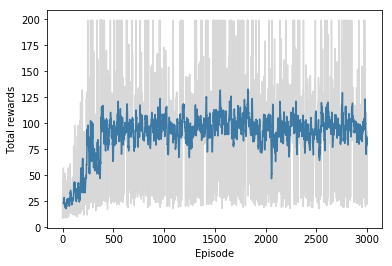

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

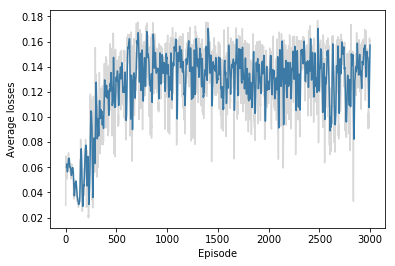

In [35]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Take one random step to get the pole and cart moving
        env.reset()
        action = env.action_space.sample()
        state, _, done, _ = env.step(action)
        reward = 1 - float(done)
            
        # New memory (time direction)
        memory.buffer.append((action, state, reward))
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.